In [25]:
import os, sys
import numpy as np
import h5netcdf

import xarray as xr
import xarray.ufuncs as xu
import pandas as pd

from matplotlib import pyplot as plt

import cartopy.crs as ccrs
import cartopy

plt.rc("font", size=14)
ccrs.PlateCarree()

from dask.distributed import Client, LocalCluster
cluster = LocalCluster(processes=False, n_workers=1, threads_per_worker=4)
client = Client(cluster)
client


/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46145 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://137.129.155.67:46145/status,
Dashboard: http://137.129.155.67:46145/status,Workers: 1
Total threads: 4,Total memory: 78.61 GiB
Status: running,Using processes: False
Comm: inproc://137.129.155.67/47389/10,Workers: 1
Dashboard: http://137.129.155.67:46145/status,Total threads: 4
Started: Just now,Total memory: 78.61 GiB
Comm: inproc://137.129.155.67/47389/13,Total threads: 4
Dashboard: http://137.129.155.67:47811/status,Memory: 78.61 GiB
Nanny: None,


In [26]:
def computeProbabilite(latm, latM, ds_skew_mean, lonm = None, lonM = None):
    if lonm != None :
        _ds = ds.sel(lat = slice(latm,latM), lon = slice(lonm,lonM)).persist()
        _ds_anom = ds_anom.sel(lat = slice(latm,latM), lon = slice(lonm,lonM)).persist()
        ds_skew_mean = ds_skew_mean.sel(lat = slice(latm,latM), lon = slice(lonm,lonM)).mean().persist()
    else :
        _ds = ds.sel(lat = slice(latm,latM)).persist()
        _ds_anom = ds_anom.sel(lat = slice(latm,latM)).persist()
        ds_skew_mean = ds_skew_mean.sel(lat = slice(latm,latM), lon = slice(lonm,lonM)).mean().persist()
    
    _ds = _ds.sum(dim = ['lat','lon']).compute()
    _ds = _ds.sel(nRange = slice(-30,30))
    
    _ds_anom = _ds_anom.sum(dim = ['lat','lon']).compute()
    _ds_anom = _ds_anom.sel(nRange = slice(-60,60))
    
    Prob = _ds.copy()
    Prob = Prob*0.
    del Prob['time']

    for v in var :
        da = _ds[v]
        Somme = 0
        for i in range(da.nRange.size):
            Somme = Somme + int(da.isel(nRange = i).values)

        Prob[v] = da/Somme

    del Prob['time']

    Prob_T = _ds_anom.copy()
    Prob_T = Prob_T*0.
    # del Prob_T['time']
    Somme = 0
    for i in range(_ds_anom.nRange.size):
        Somme = Somme + int(_ds_anom['OLR_ano'].isel(nRange = i).values)

    Prob_T['OLR_ano'] = _ds_anom['OLR_ano']/Somme

    plt.figure(figsize = (12,10))
    for v in var :
        Prob[v].rolling(nRange=3).mean().plot(label = v + ' skewness = ' + str('%.2f' % ds_skew_mean[v]), ylim = [0,0.15])
    plt.legend()
    plt.xlabel('Anomalie')
    plt.ylabel('Probabilité')
    plt.axvline(x = 0, color = 'black' )
    plt.title('Densité de Probabilité pour chaque ondes')
    plt.grid()
    plt.show()
    
    plt.figure(figsize = (12,10))
    Prob_T['OLR_ano'].rolling(nRange=3).mean().plot(label = 'anomalie'+ ' skewness = ' + str('%.2f' % ds_skew_mean['OLR_ano']), ylim = [0,0.020])
    plt.legend()
    plt.xlabel('Anomalie')
    plt.ylabel('Probabilité')
    plt.axvline(x = 0, color = 'black' )
    plt.title('Densité de Probabilité pour l anomalie totale')
    plt.grid()
    plt.show()

In [27]:
indir_data_FILTERED = '/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/ANALYSIS/DISTRIBUTION/OLR/'

ds_anom = xr.open_mfdataset(indir_data_FILTERED + 'distribution_OLR_ano_JAS.nc')

ds = xr.open_mfdataset(indir_data_FILTERED + 'distribution_OLR_MJO_JAS.nc')
da_EIG = xr.open_mfdataset(indir_data_FILTERED + 'distribution_OLR_EIG_JAS.nc')
da_WIG = xr.open_mfdataset(indir_data_FILTERED + 'distribution_OLR_WIG_JAS.nc')
da_MRG = xr.open_mfdataset(indir_data_FILTERED + 'distribution_OLR_MRG_JAS.nc')
da_Kelvin = xr.open_mfdataset(indir_data_FILTERED + 'distribution_OLR_Kelvin_JAS.nc')
da_Rossby = xr.open_mfdataset(indir_data_FILTERED + 'distribution_OLR_Rossby_JAS.nc')
da_TD = xr.open_mfdataset(indir_data_FILTERED + 'distribution_OLR_TD_JAS.nc')

# ds['OLR_EIG'] = da_EIG['OLR_EIG']
# ds['OLR_WIG'] = da_WIG['OLR_WIG']
ds['OLR_MRG'] = da_MRG['OLR_MRG']
ds['OLR_Kelvin'] = da_Kelvin['OLR_Kelvin']
ds['OLR_Rossby'] = da_Rossby['OLR_Rossby']
ds['OLR_TD'] = da_TD['OLR_TD']

# ds = ds.squeeze('variable')
var = ['OLR_MRG','OLR_Kelvin','OLR_Rossby','OLR_TD','OLR_MJO']

ds = ds.assign_coords(lon = (((ds.lon + 180) % 360) - 180)).sortby('lon')
ds = ds.assign_coords(nRange = (ds.nRange + 0.25/2))
ds

<xarray.Dataset>
Dimensions:     (nRange: 301, lat: 60, lon: 360)
Coordinates:
  * nRange      (nRange) float32 -149.9 -148.9 -147.9 ... 148.1 149.1 150.1
    time        datetime64[ns] ...
  * lat         (lat) float32 -29.5 -28.5 -27.5 -26.5 ... 26.5 27.5 28.5 29.5
  * lon         (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Data variables:
    OLR_MJO     (nRange, lat, lon) float32 dask.array<chunksize=(301, 60, 360), meta=np.ndarray>
    OLR_MRG     (nRange, lat, lon) float32 dask.array<chunksize=(301, 60, 360), meta=np.ndarray>
    OLR_Kelvin  (nRange, lat, lon) float32 dask.array<chunksize=(301, 60, 360), meta=np.ndarray>
    OLR_Rossby  (nRange, lat, lon) float32 dask.array<chunksize=(301, 60, 360), meta=np.ndarray>
    OLR_TD      (nRange, lat, lon) float32 dask.array<chunksize=(301, 60, 360), meta=np.ndarray>

In [28]:
# from scipy.stats import skew
# ds_skew = ds.reduce(skew,dim=('nRange'))

# da_skew_anom = ds_anom['OLR_ano'].reduce(skew,dim=('nRange'))
# ds_skew['OLR_ano'] = da_skew_anom

#  ds_skew.mean(dim = ['lat', 'lon'])
ds_skew_mean =xr.open_mfdataset('/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/ANALYSIS/VARIANCE/SKEW_OLR_WAVE_YEAR.nc')

_ds_skew_mean = xr.open_mfdataset('/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/ANALYSIS/VARIANCE/SKEW_OLR_ANOTOT_YEAR.nc')
ds_skew_mean['OLR_ano'] = _ds_skew_mean['OLR_ano']

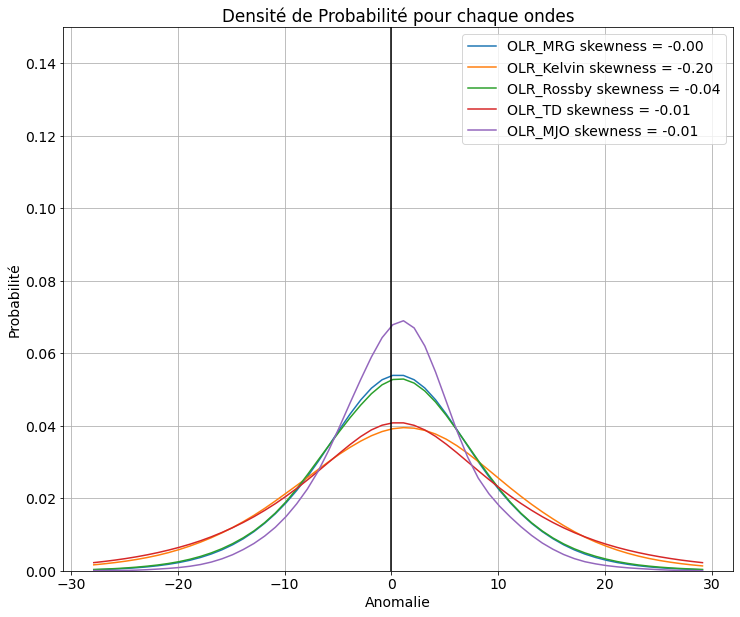

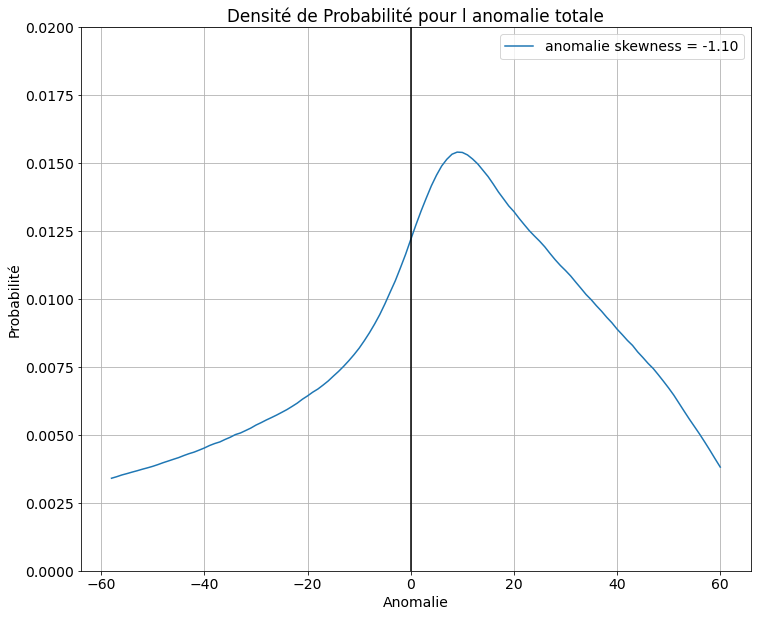

In [29]:
latm, latM = 0,15.1
computeProbabilite(latm,latM, ds_skew_mean)

# Pour la zone 1 
## lat = 0 °N à 20 °N et lon = 100 °E à 180°E

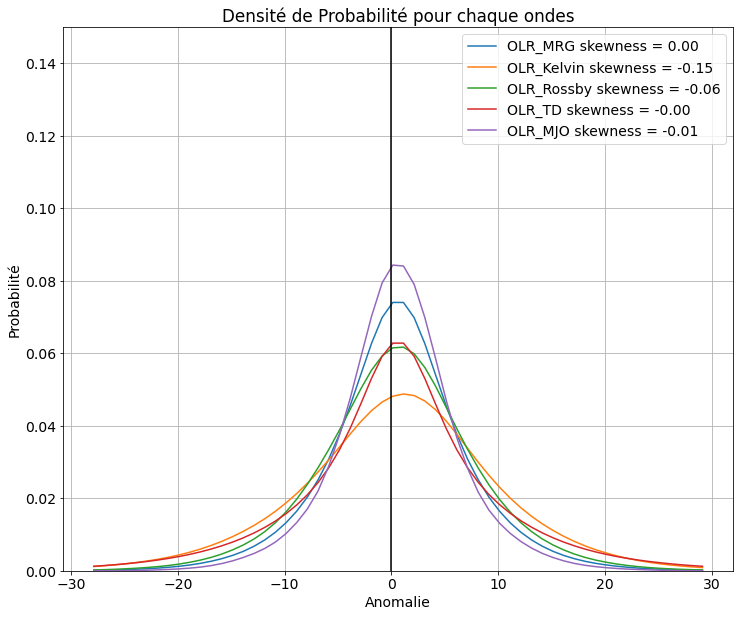

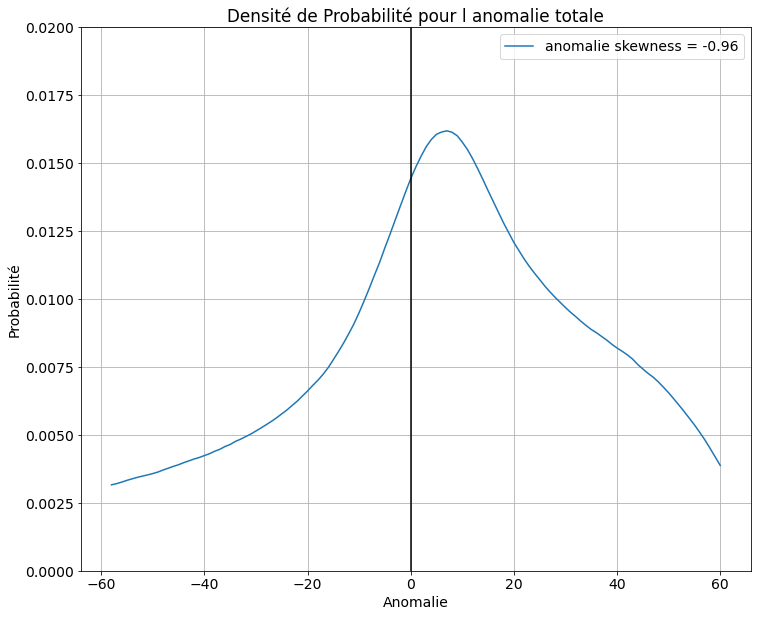

In [31]:
latm, latM = -15,15
lonm, lonM = -180, 180
computeProbabilite(latm,latM, ds_skew_mean, lonm = lonm, lonM = lonM)

# Pour la zone 2
## lat = 0 °N à 20 °N et lon = 180 °E à 270 °E

In [24]:
latm, latM = 0,20
lonm, lonM = 180, 270
computeProbabilite(latm,latM, lonm = lonm, lonM = lonM)

TypeError: computeProbabilite() missing 1 required positional argument: 'ds_skew_mean'

# Pour la zone 3
## lat = 0 °N à 20 °N et lon = 270 °E à 360 °E

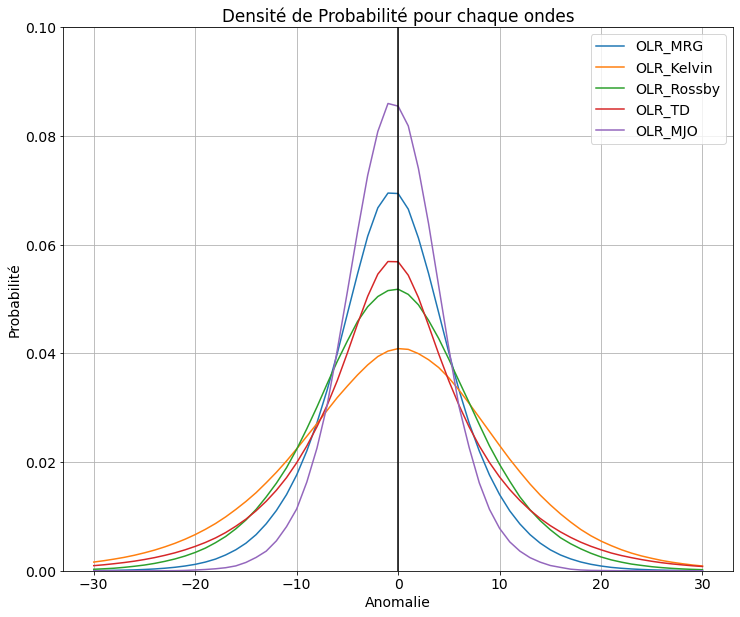

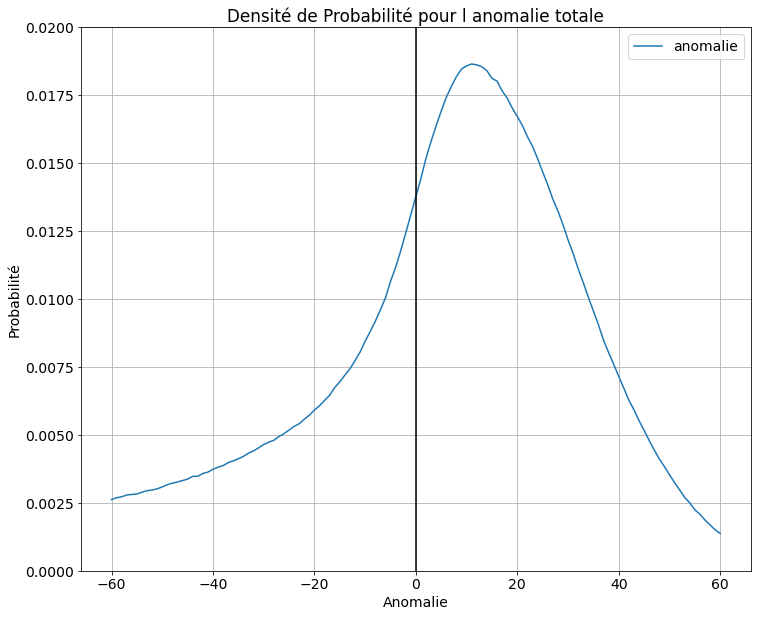

In [8]:
latm, latM = 0,20
lonm, lonM = 270, 360
computeProbabilite(latm,latM, lonm = lonm, lonM = lonM)

# Pour la zone 3b
## lat = 0 °N à 20 °N et lon = 0 °E à 100 °E

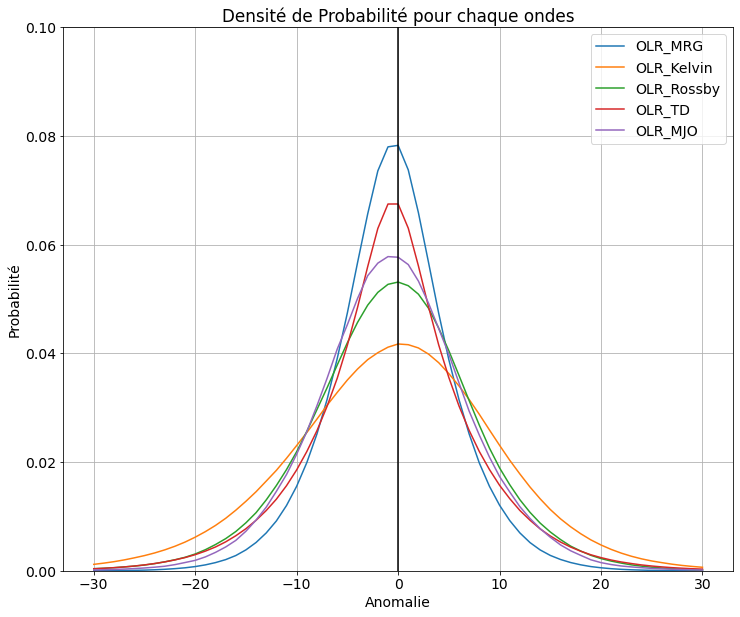

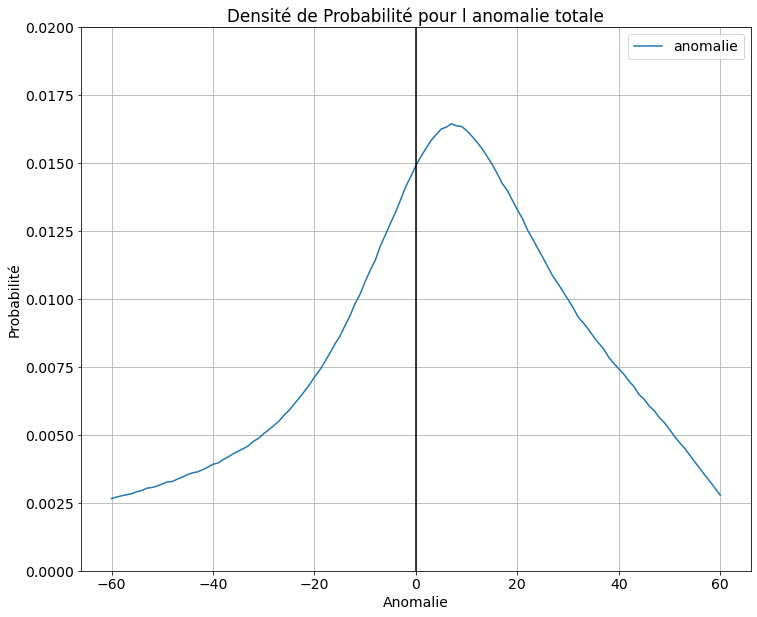

In [9]:
latm, latM = 5,15
lonm, lonM = -5, 5
computeProbabilite(latm,latM, lonm = lonm, lonM = lonM)

# Pour la zone 4
## lat = 0 °S à 20 °S et lon = 0 °E à 135 °E

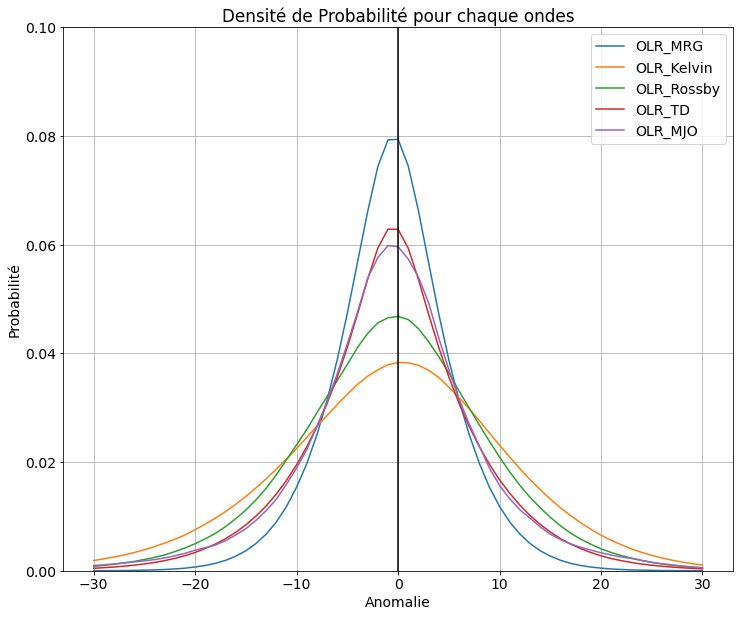

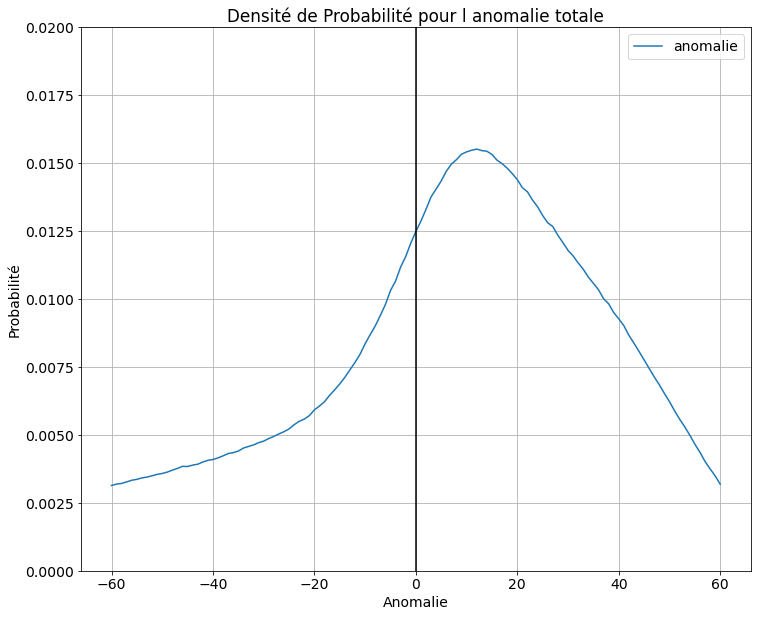

In [12]:
latm, latM = -20,0
lonm, lonM = 60, 185
computeProbabilite(latm,latM, lonm = lonm, lonM = lonM)

# Pour la zone 5
## lat = 0 °S à 20 °S et lon = 135 °E à 360 °E

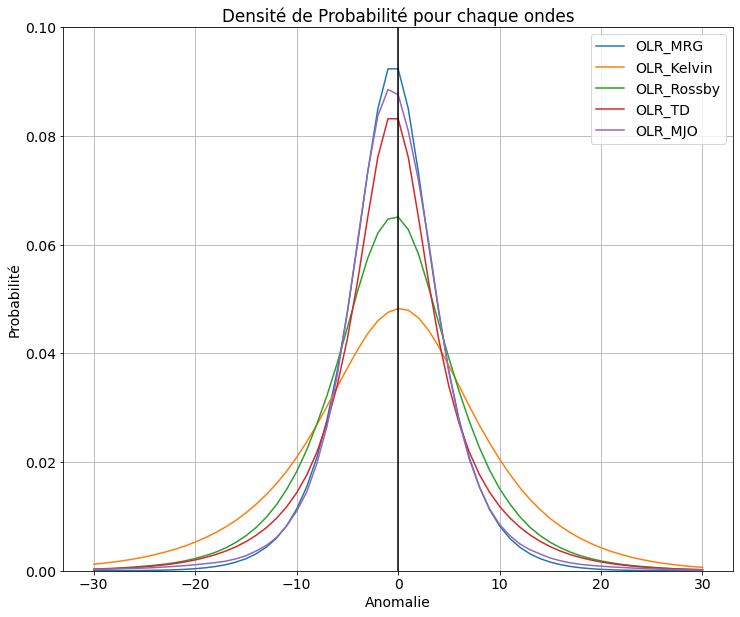

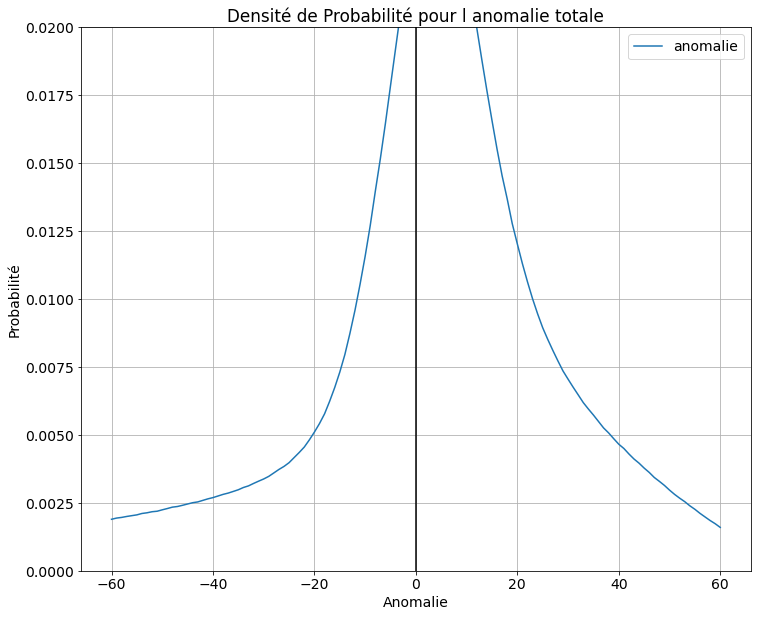

In [11]:
latm, latM = -20,0
lonm, lonM = 135, 360
computeProbabilite(latm,latM, lonm = lonm, lonM = lonM)

# Suite pour les valeurs Brut

In [11]:
ds_BRUT = xr.open_mfdataset(indir_data_FILTERED + 'distribution_BRUT_toa_lw_all_1h_JAS.nc')
ds_BRUT

OSError: no files to open

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


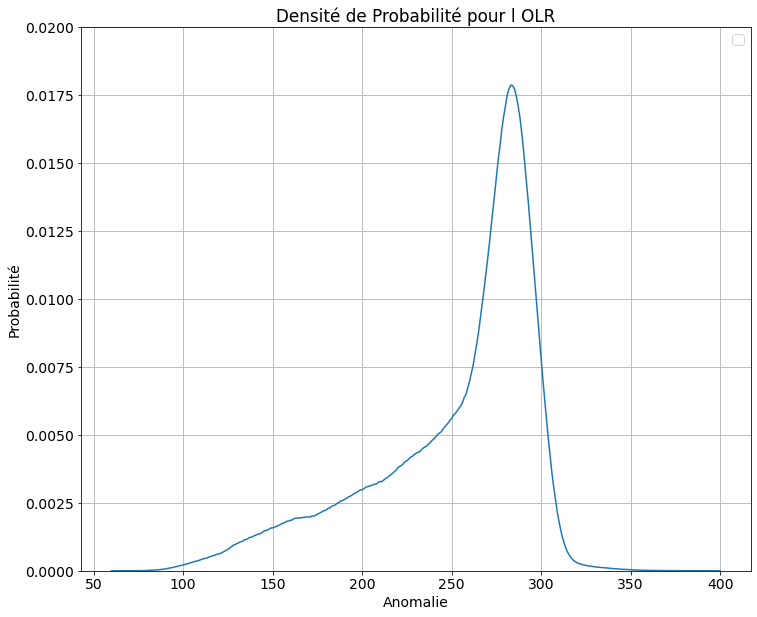

In [8]:
ds_BRUT = ds_BRUT.sel(lat = slice(0,15)).persist()
_ds_BRUT = ds_BRUT.sum(dim = ['lat','lon']).compute()

Prob_BRUT = _ds_BRUT.copy()
Prob_BRUT = Prob_BRUT * 0.
# del Prob_T['time']
Somme = 0
for i in range(_ds_BRUT.nRange.size):
    Somme = Somme + int(_ds_BRUT['toa_lw_all_1h'].isel(nRange = i).values)

Prob_BRUT['toa_lw_all_1h'] = _ds_BRUT['toa_lw_all_1h']/Somme

plt.figure(figsize = (12,10))
Prob_BRUT['toa_lw_all_1h'].plot(ylim = [0,0.02])
# _ds_anom['Sum_FILTER'].plot(label = 'Somme Filtre')
plt.legend()
plt.xlabel('Anomalie')
plt.ylabel('Probabilité')
plt.grid()
plt.title('Densité de Probabilité pour l OLR')
plt.show()